In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [2]:
tframe_left = gpd.read_file("tframe_left_look.gpkg")
tframe_left.crs = "EPSG:4326"

ERROR 1: PROJ: proj_create_from_database: Open of /home/eedy/tools/mambaforge/envs/insar/share/proj failed


In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/tmp/ipykernel_3548026/3926210268.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Axes: >

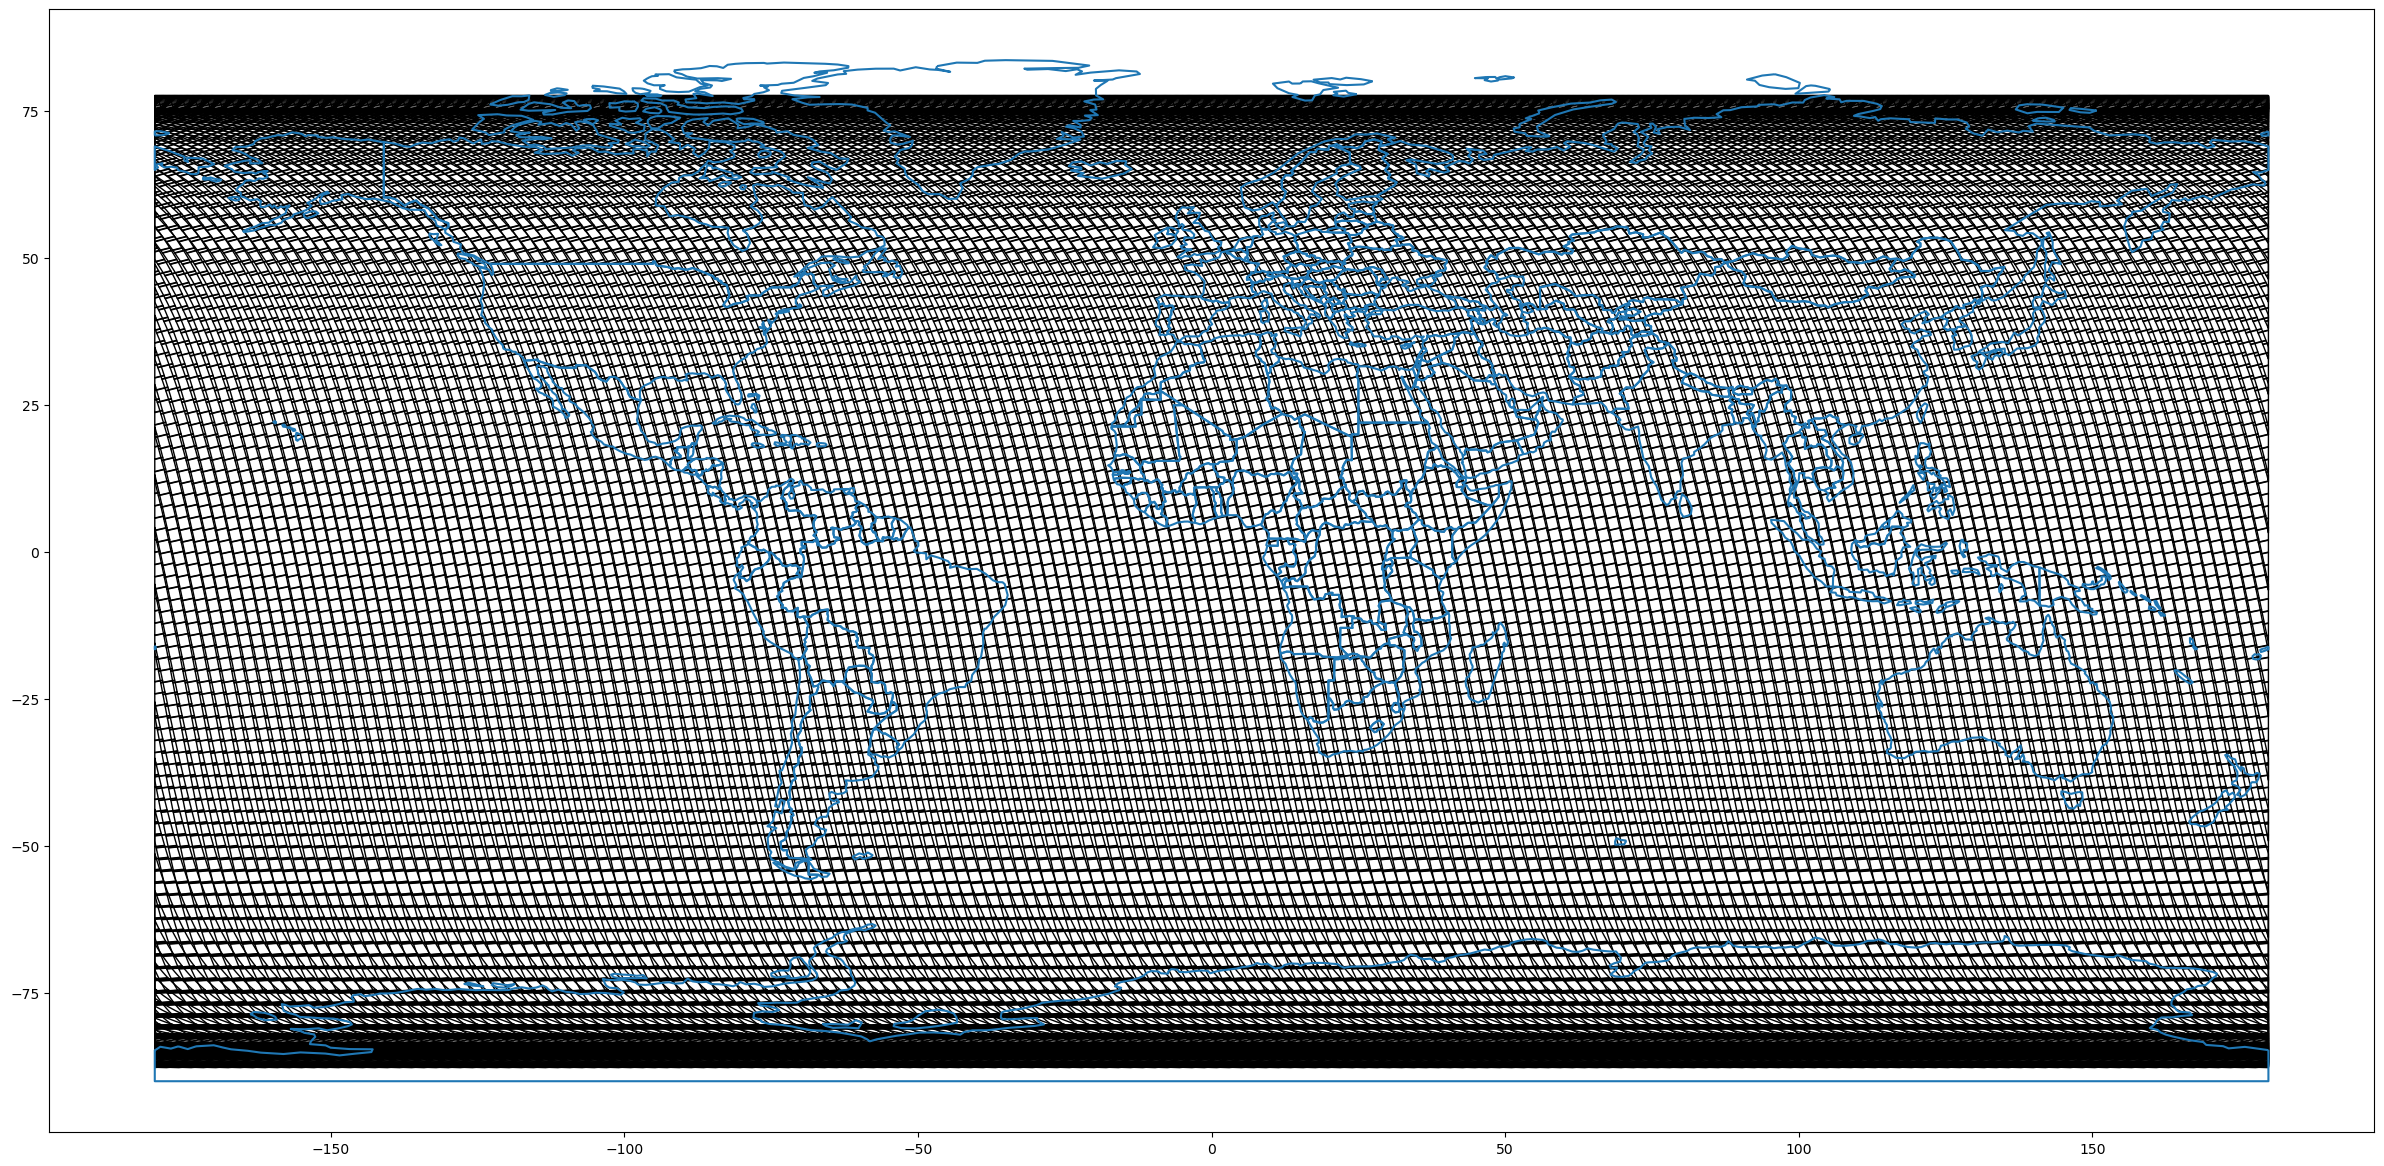

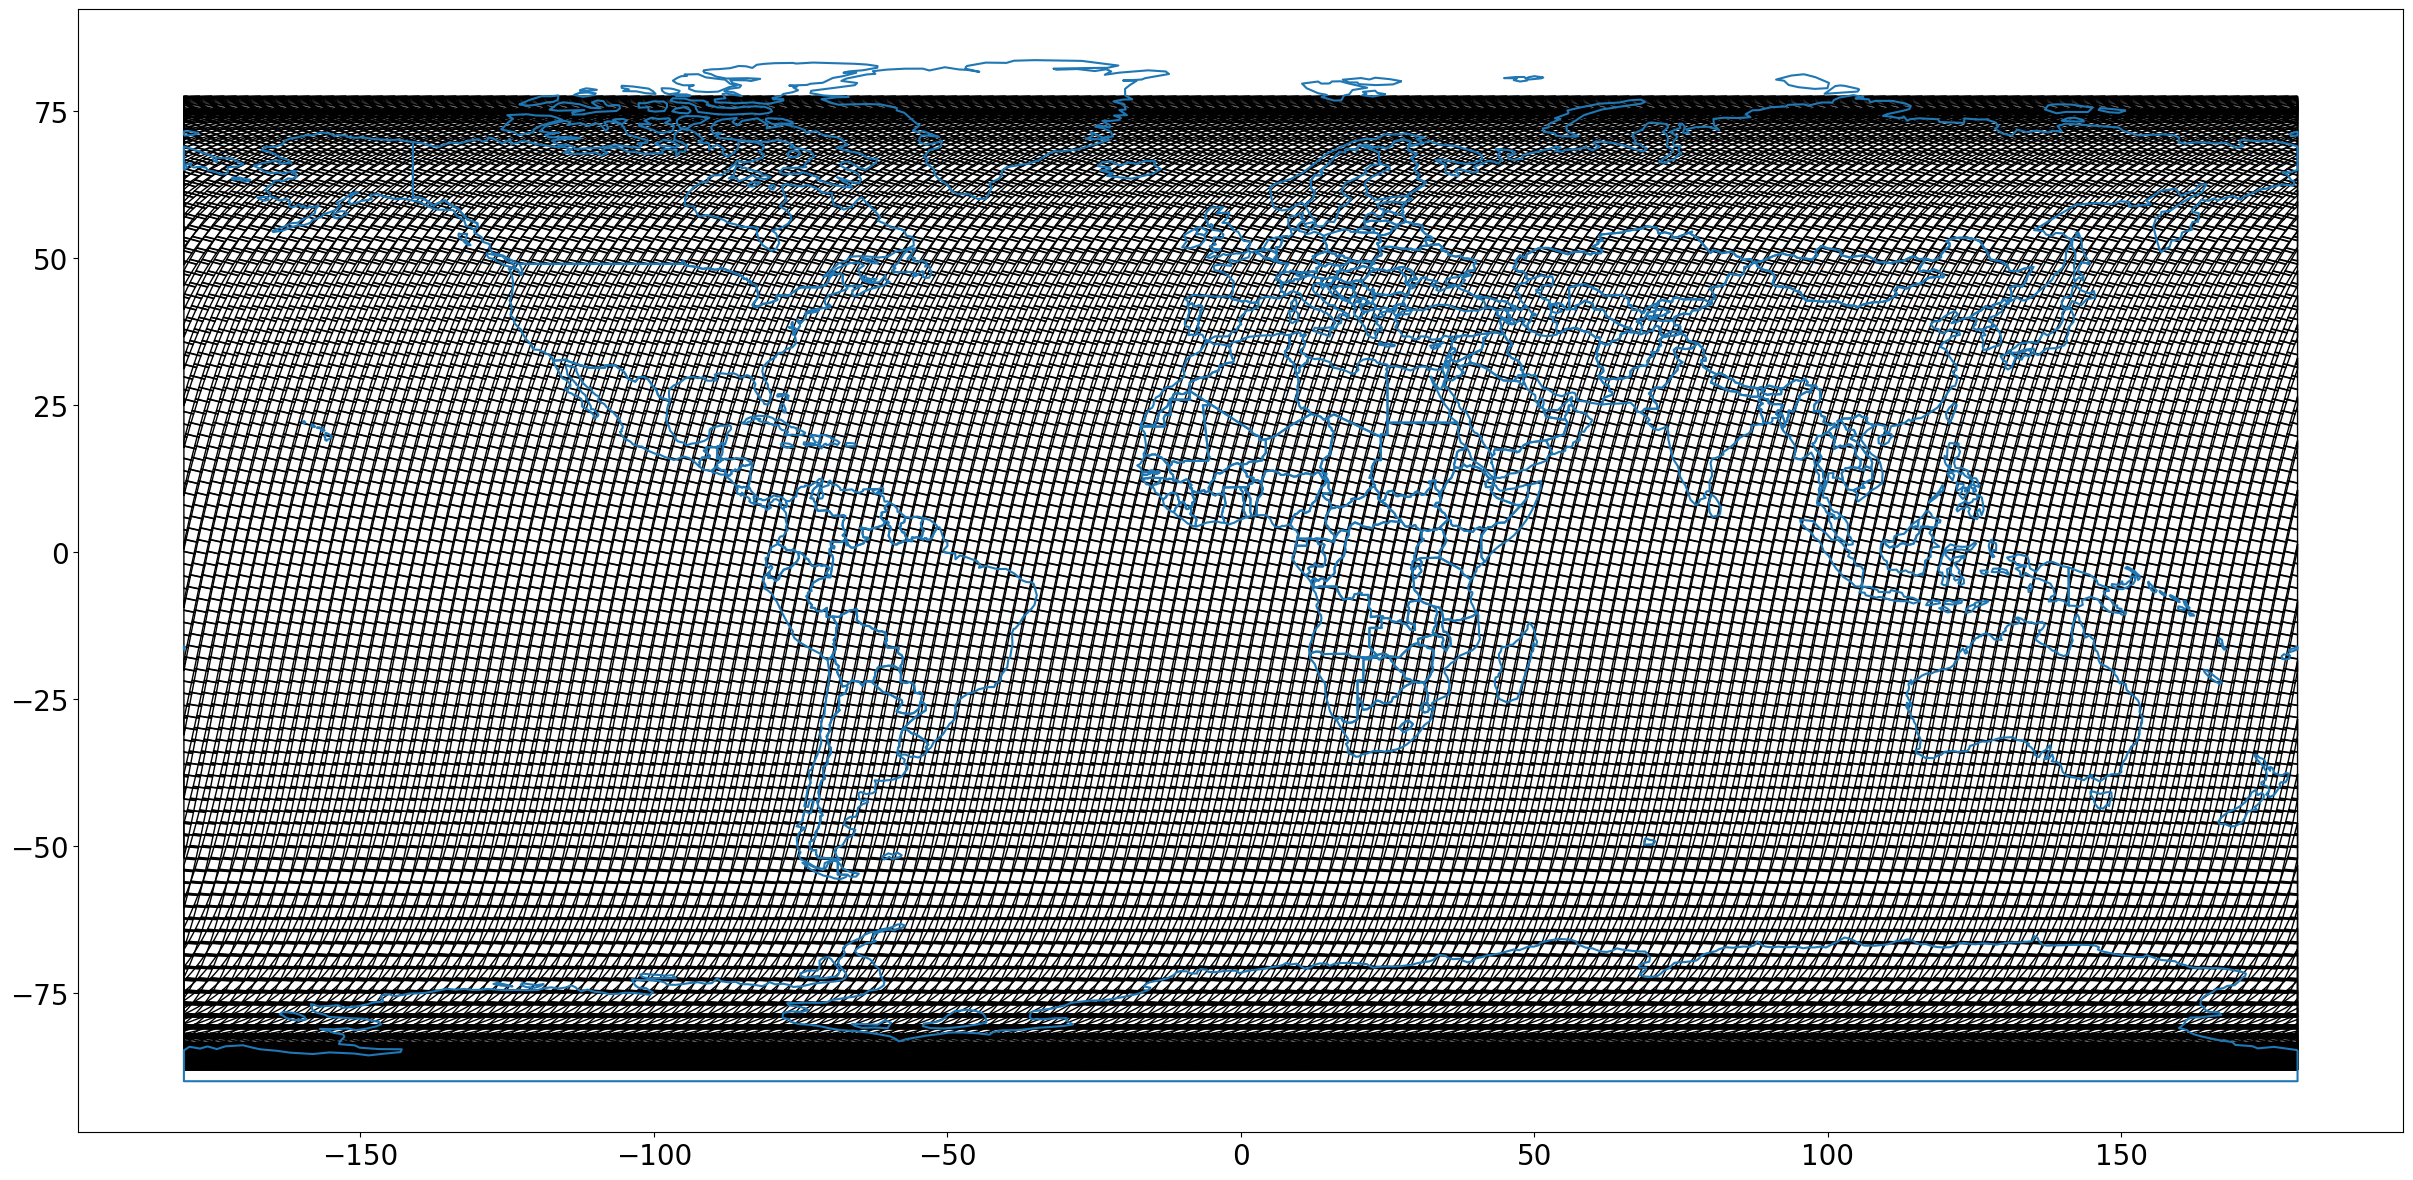

In [4]:
fig,ax = plt.subplots(1,figsize=(30,15))
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'xtick.labelsize':20})
plt.rcParams.update({'ytick.labelsize':20})


tframe_left.query("passDirection=='Ascending'").plot(
               ax=ax, facecolor="none")
world.boundary.plot(ax=ax)

fig,ax = plt.subplots(1,figsize=(30,15))
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'xtick.labelsize':20})
plt.rcParams.update({'ytick.labelsize':20})


tframe_left.query("passDirection=='Descending'").plot(
               ax=ax, facecolor="none")
world.boundary.plot(ax=ax)

In [5]:
# Example to extract UTC time for one frame
ts = tframe_left.iloc[0].startET
te = tframe_left.iloc[0].endET
tcenter = (ts + te)/2.0
frame_time_utc = datetime.datetime(2000,1,1)+datetime.timedelta(seconds=tcenter)

# 提取年月日
frame_time_date = frame_time_utc.date()
# 计算分钟数
frame_time_utc_sec = frame_time_utc.hour * 60 + frame_time_utc.minute + frame_time_utc.second / 60

print(frame_time_utc)
print(frame_time_date)
print(frame_time_utc_sec)

2022-01-01 00:33:17.722153
2022-01-01
33.28333333333333


In [6]:
# coordinates of the center of one frame
frame_cenetr = tframe_left.iloc[0].geometry.centroid
print(frame_cenetr)

POINT (-102.99603332074568 -1.0897580023450935)


In [7]:
print(tframe_left.iloc[0].satelliteLat)
print(tframe_left.iloc[0].satelliteLon)

-2.059353943039941e-05
-98.02205980089464


In [8]:
tframe_left.head

<bound method NDFrame.head of        track  frame  satelliteLat  satelliteLon  satelliteHeight  \
0          1      1     -0.000021    -98.022060    753198.181558   
1          1      2      1.999994    -98.455426    752928.450391   
2          1      3      4.000008    -98.889514    752703.250799   
3          1      4      6.000022    -99.325064    752522.603345   
4          1      5      8.000037    -99.762832    752386.319501   
...      ...    ...           ...           ...              ...   
30443    173    172    -10.000092    -95.840223    755199.332633   
30444    173    173     -8.000077    -96.281095    754714.630809   
30445    173    174     -6.000063    -96.718947    754271.196633   
30446    173    175     -4.000049    -97.154558    753870.102704   
30447    173    176     -2.000035    -97.588682    753512.213133   

      passDirection  velocityAlongTrack  velocityVertical       startET  \
0         Ascending         7571.379828         -8.728031  6.943124e+08   
1  

In [9]:
# 初始化列表
ascending_frame_time_date = []
ascending_frame_time_utc_sec = []
ascending_latitude = []
ascending_longitude = []
ascending_LookAngle = []

descending_frame_time_date = []
descending_frame_time_utc_sec = []
descending_latitude = []
descending_longitude = []
descending_LookAngle = []

# 遍历 track_frame
for index, row in tframe_left.iterrows():
    # 获取日期和时间
    startET = row['startET']
    endET = row['endET']
    tcenter = (startET + endET)/2.0
    frame_time_utc = datetime.datetime(2000,1,1)+datetime.timedelta(seconds=tcenter)
    frame_time_date = frame_time_utc.date()
    frame_time_utc_sec = frame_time_utc.hour * 60 + frame_time_utc.minute + frame_time_utc.second / 60

    # 获取入射角
    swathNearLookAngle = row['swathNearLookAngle']
    swathFarLookAngle = row['swathFarLookAngle']
    LookAngle = (swathNearLookAngle + swathFarLookAngle)/2

    # 获取经纬度
    centroid = row['geometry'].centroid
    latitude = centroid.y
    longitude = centroid.x
    
    # 根据 passDirection 来决定是 ascending 还是 descending
    pass_direction = row['passDirection']
    
    if pass_direction == 'Ascending':
        ascending_frame_time_date.append(frame_time_date)
        ascending_frame_time_utc_sec.append(frame_time_utc_sec)
        ascending_latitude.append(latitude)
        ascending_longitude.append(longitude)
        ascending_LookAngle.append(LookAngle)
    elif pass_direction == 'Descending':
        descending_frame_time_date.append(frame_time_date)
        descending_frame_time_utc_sec.append(frame_time_utc_sec)
        descending_latitude.append(latitude)
        descending_longitude.append(longitude)
        descending_LookAngle.append(LookAngle)
    else:
        # 处理其他情况，如果有的话
        pass

print(ascending_frame_time_date[1])
print(ascending_frame_time_utc_sec[1])
print(ascending_latitude[1])
print(ascending_longitude[1])
print(ascending_LookAngle[1])

2022-01-01
33.85
0.902939113257155
-103.42721892088015
35.5


In [12]:
import os
import datetime as dt
import numpy as np
import math
from scipy import interpolate
from mintpy.objects import ionex, timeseries
from mintpy.simulation import iono
from mintpy.utils import readfile, writefile
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm
from mintpy import iono_tec
from mintpy.cli import diff, ifgram_inversion, modify_network, reference_point, reference_date
from mintpy.utils import utils as ut

from datetime import datetime
from netCDF4 import Dataset

In [10]:
def compute_lat_lon_ipp(latitude , longitude , LookAngle , frame_time_utc_sec , azimuthAngle = -256):
    incidenceAngle = LookAngle

    azimuthAngle = azimuthAngle                 ########################假设升轨的方位角-256,降轨的方位角-104

    latitude = latitude

    longitude = longitude
    
    theta = incidenceAngle*np.pi/180
    Re = 6371000
    h_ipp = 450e3
    theta_ipp = np.arcsin(Re*np.sin(theta)/(Re+h_ipp))
    HEADING = azimuthAngle*np.pi/180

    alpha_ipp = theta - theta_ipp

    latitude_pi = latitude *np.pi/180
    longitude_pi = longitude *np.pi/180

    lat_ipp_pi = np.arcsin(np.sin(latitude_pi)*np.cos(alpha_ipp) + np.cos(latitude_pi)*np.sin(alpha_ipp)*np.cos(HEADING))
    atan2_func = np.vectorize(math.atan2)
    delta = atan2_func(-np.sin(alpha_ipp)*np.cos(latitude_pi)*np.sin(HEADING), np.cos(alpha_ipp) - np.sin(latitude_pi)*np.sin(lat_ipp_pi))
    lon_ipp_pi = np.mod(longitude_pi + delta + np.pi, 2*np.pi) - np.pi

    lat_ipp = lat_ipp_pi *180/np.pi
    lon_ipp = lon_ipp_pi *180/np.pi

    return lat_ipp, lon_ipp ,theta_ipp

In [16]:
## 计算电离层穿透的经纬度位置和折射角度
lat_ipp, lon_ipp ,theta_ipp = compute_lat_lon_ipp(ascending_latitude[1] , ascending_longitude[1] , ascending_LookAngle[1] , ascending_frame_time_utc_sec[1] , azimuthAngle = -256)
print(lat_ipp)
print(lon_ipp)
print(theta_ipp)

0.260339913773178
-106.00172717248765
0.5732821657118503


In [33]:
def read_netcdf_file(frame_time_date):
    # Open the NetCDF file for reading
    date_obj = frame_time_date
    date_str = date_obj.strftime('%Y-%m-%d')
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    day_of_year = date_obj.timetuple().tm_yday
    year_last_two = date_obj.strftime('%y')
    filename = f"/home/eedy/data/aux/IONEX/jpld{day_of_year:03d}0.{year_last_two}i.nc"

    dataset = Dataset(filename, 'r')

    # Get the data variables
    varepochs_data = dataset.variables['varepochs'][:]
    time_data = dataset.variables['time'][:]
    lats = dataset.variables['lat'][:]
    lons = dataset.variables['lon'][:]
    tec_maps = dataset.variables['tecmap'][:]
    tec_flag = dataset.variables['tecflag'][:]

    # Close the NetCDF file
    dataset.close()

    mins = []
    for varepoch in varepochs_data:
        dt = datetime.strptime(varepoch, "%Y/%m/%d_%H:%M:%S")
        total_minutes = dt.hour * 60 + dt.minute + dt.second / 60
        mins.append(total_minutes)
    
    # Return the data
    return varepochs_data, time_data, lats, lons, tec_maps, tec_flag , mins

In [38]:
varepochs_data, time_data, lats, lons, tec_maps, tec_flag , mins = read_netcdf_file(ascending_frame_time_date[1])
print(tec_maps[10])
print(lats[9])

[[ 0.7  0.7  0.7 ...  0.7  0.7  0.7]
 [ 0.9  0.9  0.9 ...  0.8  0.9  0.9]
 [ 1.   1.   1.  ...  0.9  1.   1. ]
 ...
 [12.7 12.7 12.7 ... 12.7 12.7 12.7]
 [12.5 12.5 12.5 ... 12.5 12.5 12.5]
 [12.3 12.3 12.3 ... 12.3 12.3 12.3]]
80.5


In [57]:
def compute_r_iono(frame_time_utc_sec, frame_time_date, latitude , longitude, LookAngle , azimuthAngle = -256):
    lat_ipp, lon_ipp ,theta_ipp = compute_lat_lon_ipp(latitude , longitude, LookAngle , frame_time_utc_sec , azimuthAngle = -256 )
    varepochs, time, lats, lons, tec_maps, tecflag , mins= read_netcdf_file(frame_time_date)
    
    minutes1 = frame_time_utc_sec
    for i in range(len(mins) - 1):
        if minutes1 >= mins[i] and minutes1 <= mins[i+1]:
            break

    valid_mask = ~(np.isnan(lat_ipp) | np.isnan(lon_ipp))
    valid_lat_ipp = lat_ipp[valid_mask]
    valid_lon_ipp = lon_ipp[valid_mask]

    interp_func = RegularGridInterpolator((mins, lats, lons), tec_maps, method='linear')

    Ei = np.column_stack((np.full(valid_lat_ipp.size, mins[i]),
                          valid_lat_ipp,
                          valid_lon_ipp + (minutes1 - mins[i]) * 360. / (24. * 60.)))

    Ei1 = np.column_stack((np.full(valid_lat_ipp.size, mins[i+1]),
                           valid_lat_ipp,
                           valid_lon_ipp + (minutes1 - mins[i+1]) * 360. / (24. * 60.)))

    new_tec_map1 = np.full_like(lat_ipp, np.nan)
    new_tec_map1[valid_mask] = ((mins[i+1] - minutes1) / (mins[i+1] - mins[i]) * interp_func(Ei) + (minutes1 - mins[i]) / (mins[i+1] - mins[i]) * interp_func(Ei1))

    k = 40.31
    c = 299792458
    freq = 1.257e9
    h_ipp = 450e3
    Re = 6371000
   
    VTEC = new_tec_map1*1e16
    a = VTEC * k / (freq ** 2)
    r_iono = a / np.cos(np.arcsin(np.sin(theta_ipp) / (1 + a)))
    
    return r_iono

In [58]:
r_iono = compute_r_iono(ascending_frame_time_utc_sec[40], ascending_frame_time_date[40], ascending_latitude[40] , ascending_longitude[40] , ascending_LookAngle[40] , azimuthAngle = -256)
print(r_iono)

0.8022316576123287


In [94]:
r_iono = []
for i in range(len(ascending_frame_time_utc_sec)):
    try:
        result = compute_r_iono(ascending_frame_time_utc_sec[i], ascending_frame_time_date[i], ascending_latitude[i], ascending_longitude[i], ascending_LookAngle[i], azimuthAngle=-256)
    except Exception as e:
        print(f"Error occurred: {e}")
        result = np.nan
    r_iono.append(result)

Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dime

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 假设r_iono是您的数组值，ascending_latitude和ascending_longitude是对应的经纬度数组

# 创建地图投影
plt.figure(figsize=(20, 12))
ax = plt.axes(projection=ccrs.PlateCarree())

# 添加地形轮廓背景，仅画出黑色轮廓线
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
ax.add_feature(cfeature.BORDERS, edgecolor='black')

# 调整点的大小和透明度
sc = ax.scatter(ascending_longitude, ascending_latitude, c=r_iono, cmap='viridis', s=22, alpha=1, transform=ccrs.PlateCarree())

# 添加颜色条并调整尺寸
cbar = plt.colorbar(sc, label='ionospheric delay [m]')
cbar.ax.set_position([0.8, 0.3, 0.03, 0.4])  # Adjust the position and size of the colorbar (left, bottom, width, height)

plt.title('ionospheric delay Distribution [NISAR]')
plt.show()

In [96]:
r_iono = []
for i in range(len(ascending_frame_time_utc_sec)):
    try:
        result = compute_r_iono(descending_frame_time_utc_sec[i], descending_frame_time_date[i], descending_latitude[i], descending_longitude[i], descending_LookAngle[i], azimuthAngle=-104)
    except Exception as e:
        print(f"Error occurred: {e}")
        result = np.nan
    r_iono.append(result)

Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dimension 2
Error occurred: One of the requested xi is out of bounds in dime

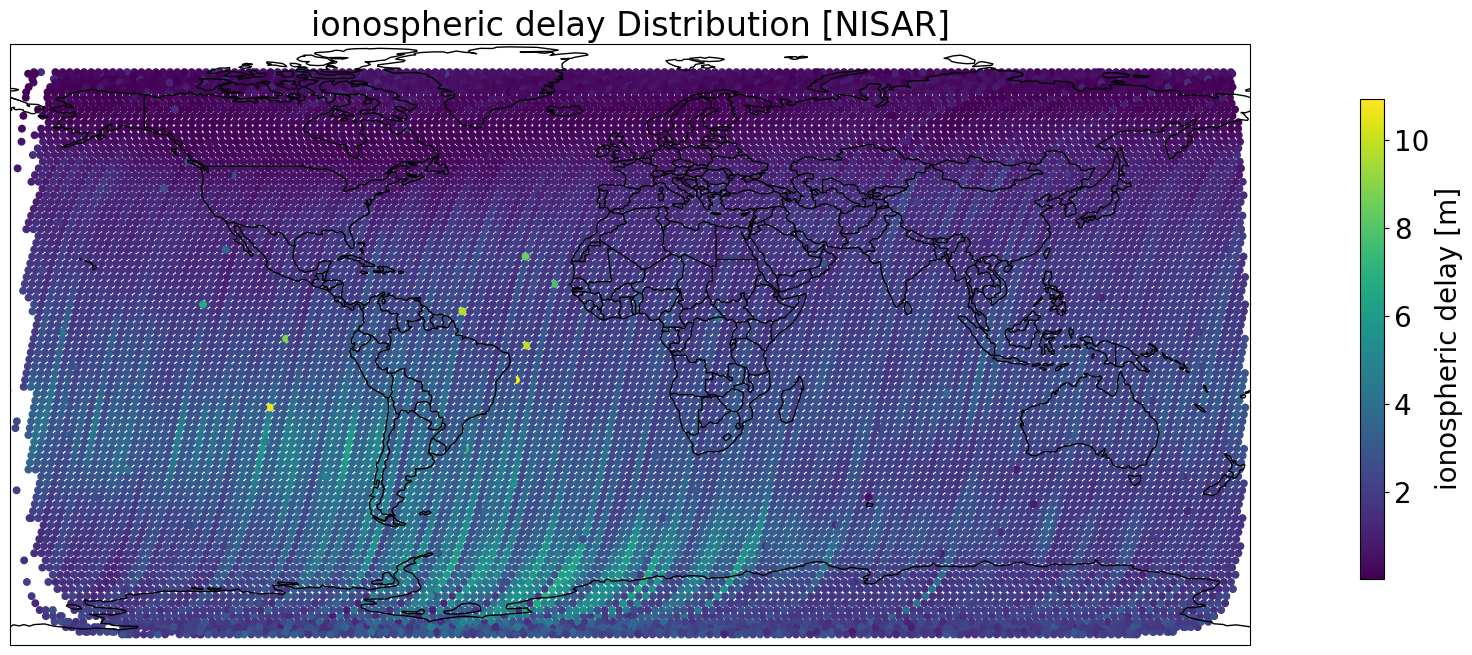

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 假设r_iono是您的数组值，ascending_latitude和ascending_longitude是对应的经纬度数组

# 创建地图投影
plt.figure(figsize=(20, 12))
ax = plt.axes(projection=ccrs.PlateCarree())

# 添加地形轮廓背景，仅画出黑色轮廓线
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
ax.add_feature(cfeature.BORDERS, edgecolor='black')

# 调整点的大小和透明度
sc = ax.scatter(descending_longitude, descending_latitude, c=r_iono, cmap='viridis', s=22, alpha=1, transform=ccrs.PlateCarree())

# 添加颜色条并调整尺寸
cbar = plt.colorbar(sc, label='ionospheric delay [m]')
cbar.ax.set_position([0.8, 0.3, 0.03, 0.4])  # Adjust the position and size of the colorbar (left, bottom, width, height)

plt.title('ionospheric delay Distribution [NISAR]')
plt.show()